### Using Python to read contents of PDF using OCR

##### ⚠️ If you’re using multiple versions of Python (e.g., 3.12, 3.10), make sure pip matches the right version:

In [ ]:
!python -m pip install pytesseract #A Python wrapper for Google’s Tesseract OCR engine
!python -m pip install pdf2image #To convert PDF files into images
!python -m pip install scipy
!python -m pip install opencv-python #For image preprocessing tasks like deskewing and grayscale conversion
!python -m pip install pandas

Poppler path exists!


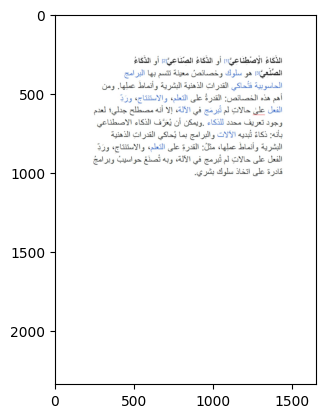

In [3]:
import pytesseract
from PIL import Image
from pdf2image import convert_from_path
from scipy import ndimage
import numpy as np
import cv2
import math
import sys
import os
from matplotlib import pyplot as plt

# pytesseract.pytesseract.tesseract_cmd = r'C:\Users\fkhaldi\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
# poppler_path = r'C:\Users\fkhaldi\Documents\SUPMTI\PFA\colab\Release-24.08.0-0\poppler-24.08.0\Library\bin'

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
poppler_path = r'C:\Users\ProBook\Documents\PFA\Release-24.08.0-0\poppler-24.08.0\Library\bin'

if os.path.isdir(poppler_path):
    print("Poppler path exists!")
else:
    print("Poppler path does not exist!")
# PDF_file = "../uploads/NASDAQ_ASLN_2019.pdf"
# PDF_file = "../uploads/avis_concours.pdf"
# PDF_file = "../uploads/facture-avoir.pdf"
PDF_file = "../uploads/arabic_file.pdf"

# images = convert_from_path(PDF_file, poppler_path=poppler_path)

# images[0].show()

IMAGE_FILE_LOCATION = "../uploads/images/page_1.jpg"
img = Image.open(IMAGE_FILE_LOCATION)
plt.imshow(img)

In [4]:
'''
Part #1 : Converting PDF to images
'''

# Store all the pages of the PDF in a variable
pages = convert_from_path(PDF_file, 200, poppler_path=poppler_path)
# pages = convert_from_path(PDF_file, poppler_path=poppler_path)

# Counter to store images of each page of PDF to image
image_counter = 1

# Iterate through all the pages stored above
for page in pages:
    # Declaring filename for each page of PDF as JPG
    # For each page, filename will be:
    # PDF page 1 -> page_1.jpg
    # PDF page 2 -> page_2.jpg
    # PDF page n -> page_n.jpg
    filename = "../uploads/images/page_"+str(image_counter)+".jpg"

    # Save image of the page in system
    page.save(filename, 'JPEG')

    # Increase counter to update filename
    image_counter = image_counter + 1

In [5]:

'''
Part #2 - Recognising text from the images using OCR
'''

# Variable to get count of total number of pages
filelimit = image_counter-1

# Create a text file to write the output
outfile = "../outputs/output_text.txt"

In [9]:
# Open the file in append mode so that contents of all images are added to the same file
f = open(outfile, "a", encoding="utf-8")

# Iterate from 1 to the total number of pages
for i in range(1, filelimit + 1):

    # Set filename to recognize text from
    # page_1.jpg
    # page_2.jpg
    # page_n.jpg
    filename = "../uploads/images/page_"+str(i)+".jpg"

    # # Load image and preprocess
    # img = cv2.imread(filename)
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # gray = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)[1]  # binarization
    # gray = cv2.medianBlur(gray, 3)

    # Optional: Save to verify output
    # cv2.imwrite("../uploads/images/cleaned_"+str(i)+".jpg", gray)

    # Load and preprocess
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)  # Noise reduction
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Save cleaned image (optional)
    cv2.imwrite("../uploads/images/cleaned_"+str(i)+".jpg", gray)

    # Recognise the text as string in image using pytesserct
    # text = str(((pytesseract.image_to_string(Image.open(filename), lang="ara"))))  # or 'fra', 'ara', etc
    custom_config = r'--oem 3 --psm 3 -l ara'
    # text = pytesseract.image_to_string(thresh, config=custom_config)
    text = str(((pytesseract.image_to_string(thresh, config=custom_config , lang="ara"))))  # or 'fra', 'ara', etc

    # The recognized text is stored in variable text
    # Any string processing may be applied on text
    # Basic formatting has been performed
    # In many PDFs, if a word can't be written fully at line ending, a 'hyphen' is added
    # The rest of the word is written in the next line
    # Replace every '-\n' to '' to remove such hyphens
    # text = text.replace('-\n', '')

    # Write the processed text to the file
    f.write(text)

# Close the file after writing all the text
f.close()

### Using Tesseract OCR to localise and detect text

In [89]:
# Read input image
IMAGE_FILE_LOCATION = "../uploads/images/page_1.jpg"
input_img = cv2.imread(IMAGE_FILE_LOCATION)

scale_percent = 50 # Percent of original size
width = int(input_img.shape[1] * scale_percent / 100)
height = int(input_img.shape[0] * scale_percent / 100)
dim = (width, height)

# Resize input image
resized = cv2.resize(input_img, dim, interpolation = cv2.INTER_AREA)

#### Step 1: Select the region of interest (“ROI”) from the resized input image using the mouse.

In [90]:
# Initialize the list for storing the coordinates 
coordinates = [] 
  
# Define callback function
def shape_selection(event, x, y, flags, param): 
    global coordinates # Make coordinates global
  
    # Store the (x1,y1) coordinates when left mouse button is pressed  
    if event == cv2.EVENT_LBUTTONDOWN: 
        coordinates = [(x, y)] 
  
    # Store the (x2,y2) coordinates when the left mouse button is released and make a rectangle on the selected region
    elif event == cv2.EVENT_LBUTTONUP: 
        coordinates.append((x, y)) 
  
        # Draw a rectangle around the region of interest
        cv2.rectangle(image, coordinates[0], coordinates[1], (0,0,255), 2) 
        cv2.imshow("image", image) 
        
# Load and make a copy of the image, and setup the mouse callback function 
image = resized
image_copy = image.copy()
cv2.namedWindow("image") 
cv2.setMouseCallback("image", shape_selection) 
   
# Keep looping until the 'q' key is pressed 
while True: 
    # Display the image and wait for a keypress 
    cv2.imshow("image", image) 
    key = cv2.waitKey(1) & 0xFF
  
    if key==13: # If 'enter' is pressed, apply OCR
        break
    
    if key == ord("c"): # Clear the selection when 'c' is pressed 
        image = image_copy.copy() 

# if len(coordinates) == 2: 
#     image_roi = image_copy[coordinates[0][1]:coordinates[1][1],
#                            coordinates[0][0]:coordinates[1][0]] 
#     cv2.imshow("Selected Region of Interest - Press any key to proceed", image_roi) 
#     cv2.waitKey(0) 

if len(coordinates) == 2: 
    print("[INFO] Coordinates received. Cropping ROI...")  # Debug print
    image_roi = image_copy[coordinates[0][1]:coordinates[1][1],
                           coordinates[0][0]:coordinates[1][0]] 
    cv2.imshow("Selected Region of Interest - Press any key to proceed", image_roi) 
    cv2.waitKey(0) 
else:
    print("[WARNING] ROI not selected properly. Length of coordinates:", len(coordinates))


# Close all open windows 
cv2.destroyAllWindows()  

[INFO] Coordinates received. Cropping ROI...


#### Step 2: Perform Tesseract OCR on the region of interest selected and print the output text.

In [91]:
print(image_roi.shape)

text = pytesseract.image_to_string(image_roi)
print("The text in the selected region is as follows:\n")
print(text)

(32, 42, 3)
The text in the selected region is as follows:


